# Predicting Credit Risk using PySpark

This is a binary classification task - predicting whether a person will default on a loan or not based on information provided on the application. This is being used as an opportunity to practice using PySpark.

The data was obtained through Kaggle: https://www.kaggle.com/c/home-credit-default-risk/data

In [1]:
from pyspark.sql import SparkSession

#initiate session
spark = SparkSession.builder.appName('imbalanced_binary_classification').getOrCreate()

#read CSV file and print dataframe schema
df = spark.read.csv('home-credit-default-risk/application_train.csv', header=True, inferSchema=True)
df.printSchema()

root
 |-- SK_ID_CURR: integer (nullable = true)
 |-- TARGET: integer (nullable = true)
 |-- NAME_CONTRACT_TYPE: string (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)
 |-- AMT_GOODS_PRICE: double (nullable = true)
 |-- NAME_TYPE_SUITE: string (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- REGION_POPULATION_RELATIVE: double (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- DAYS_REGISTRATION: double (nullable = true)
 |-- DAYS_ID_PUBLISH: integer (nullable = true)
 |-- OWN_CAR_AG

In [2]:
#Sk_ID_Curr is the id column - not needed, so dropped 
drop_col = ['SK_ID_CURR']
df = df.select([column for column in df.columns if column not in drop_col])

#rename name of target variable to "label"
df = df.withColumnRenamed('TARGET', 'label')

#count number of each label in target variable
df.groupby('label').count().toPandas()

,label,count
0,1,24825
1,0,282686


307511


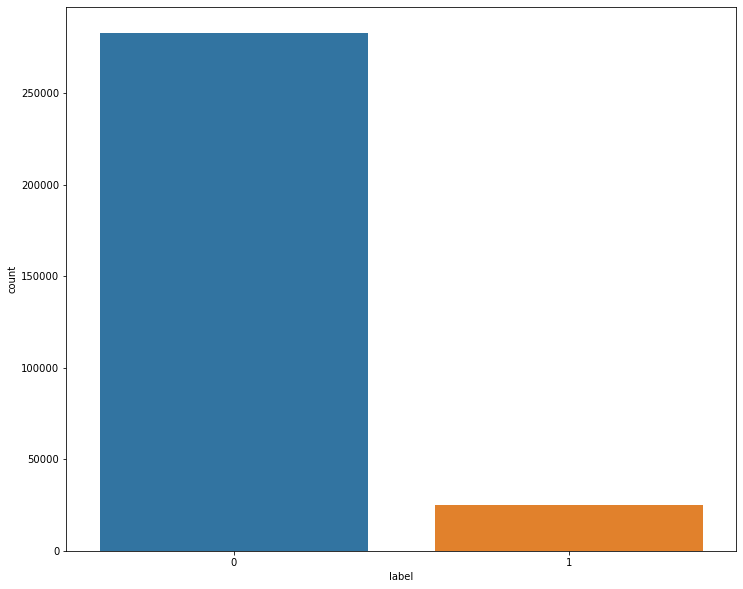

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
df_pd = df.toPandas()
print(len(df_pd))
plt.figure(figsize=(12,10))
sns.countplot(x='label', data=df_pd, order=df_pd['label'].value_counts().index)

This is clearly an imbalanced classification task - there are substantially more entries that repay their loan compared to those who do not.

## Exploration of Data

In [4]:
import pandas as pd
pd.DataFrame(df.take(10), columns = df.columns)

,label,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,454500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
6,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,1395000.0,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0
7,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,1530000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
8,0,Cash loans,F,N,Y,0,112500.0,1019610.0,33826.5,913500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
9,0,Revolving loans,M,N,Y,0,135000.0,405000.0,20250.0,405000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#number of categorical and numerical features
cat_cols = [item[0] for item in df.dtypes if item[1].startswith('string')] 
print(str(len(cat_cols)) + '  categorical features')

num_cols = [item[0] for item in df.dtypes if item[1].startswith('int') | item[1].startswith('double')][1:]
print(str(len(num_cols)) + '  numerical features')

16  categorical features
104  numerical features


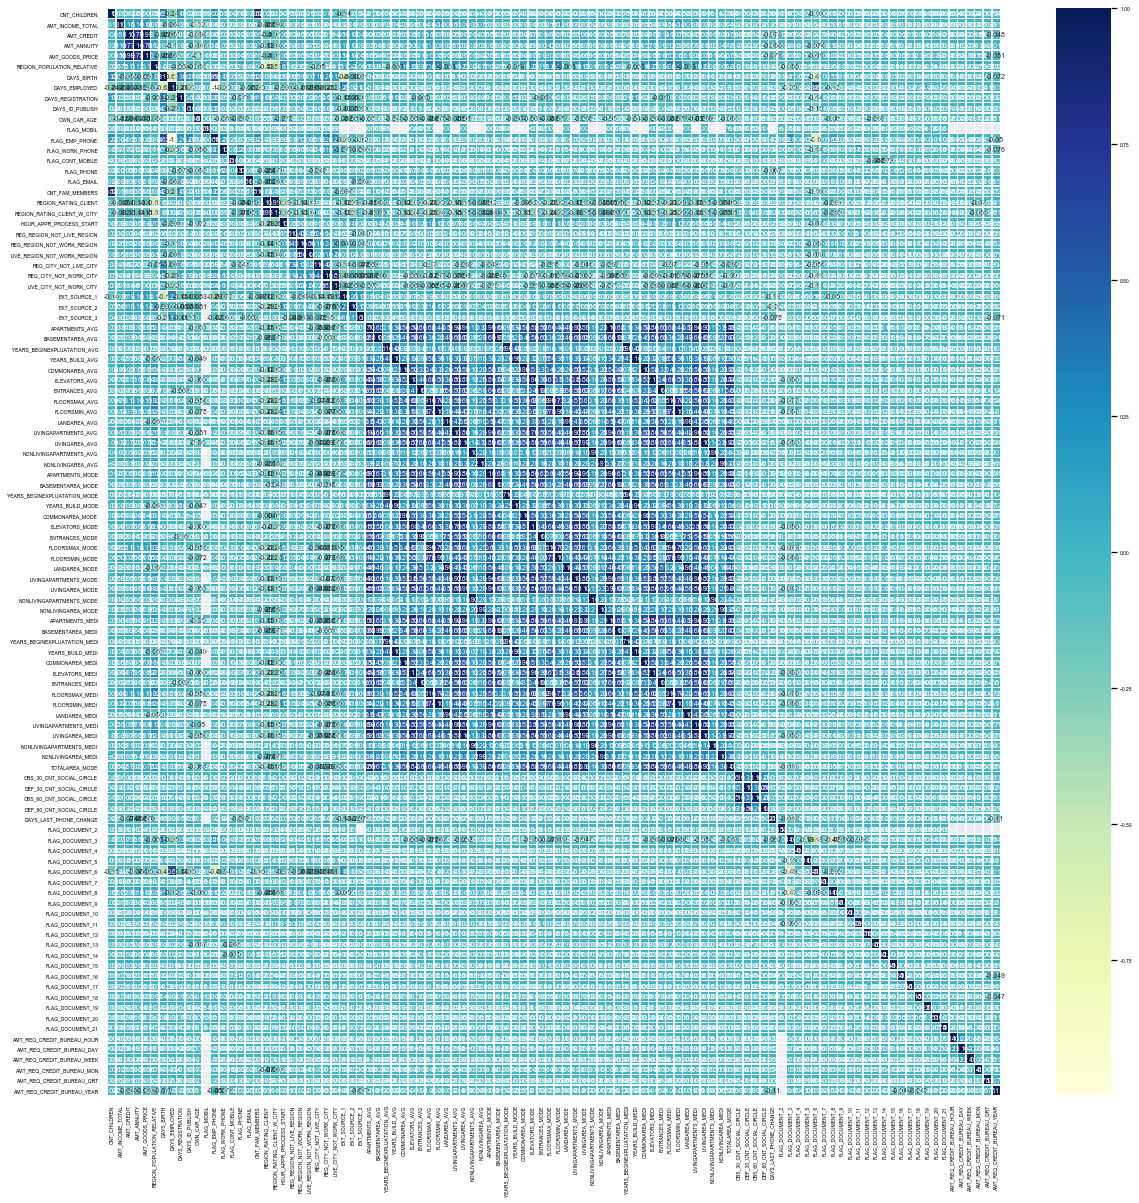

In [6]:
#correlation heatmap of numerical features
import seaborn as sns; sns.set()
correlation_df = df.select(num_cols).toPandas().corr()

sns.set(rc={"font.style":"normal",
            "axes.titlesize":20,
            "text.color":"black",
            "xtick.color":"black",
            "ytick.color":"black",
            "axes.labelcolor":"black",
            "axes.grid":False,
            'axes.labelsize':30,
            'figure.figsize':(20, 20),
            'xtick.labelsize':5,
            'ytick.labelsize':5})
sns.heatmap(correlation_df, annot = True, annot_kws={"size": 7}, cmap="YlGnBu", linewidths=.5)

In [7]:
#function to find more information about missing values
def info_missing_table(df_pd):
    """Input pandas dataframe and Return columns with missing value and percentage"""
    mis_val = df_pd.isnull().sum() #count total of null in each columns in dataframe
    mis_val_percent = 100 * df_pd.isnull().sum() / len(df_pd) #count percentage of null in each columns
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)  #join to left (as column) between mis_val and mis_val_percent
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'}) #rename columns in table
    mis_val_table_ren_columns = mis_val_table_ren_columns[
    mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)         
    print ("Your selected dataframe has " + str(df_pd.shape[1]) + " columns.\n"  
    "There are " + str(mis_val_table_ren_columns.shape[0]) +              
    " columns that have missing values.") 
    return mis_val_table_ren_columns

In [8]:
missings = info_missing_table(df_pd)
missings

Your selected dataframe has 121 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
...,...,...
EXT_SOURCE_2,660,0.2
AMT_GOODS_PRICE,278,0.1
AMT_ANNUITY,12,0.0
CNT_FAM_MEMBERS,2,0.0


In [9]:
#function to deal with spark dataframe directly to find more about missing values
def count_missings(spark_df):
    null_counts = []        
    for col in spark_df.dtypes:    
        cname = col[0]     
        ctype = col[1]      
        nulls = spark_df.where( spark_df[cname].isNull()).count() #check count of null in column name
        result = tuple([cname, nulls])  #new tuple, (column name, null count)
        null_counts.append(result)      #put the new tuple in our result list
    null_counts=[(x,y) for (x,y) in null_counts if y!=0]  #view just columns that have missing values
    return null_counts

In [10]:
miss_counts = count_missings(df)
miss_counts

[('AMT_ANNUITY', 12),
 ('AMT_GOODS_PRICE', 278),
 ('NAME_TYPE_SUITE', 1292),
 ('OWN_CAR_AGE', 202929),
 ('OCCUPATION_TYPE', 96391),
 ('CNT_FAM_MEMBERS', 2),
 ('EXT_SOURCE_1', 173378),
 ('EXT_SOURCE_2', 660),
 ('EXT_SOURCE_3', 60965),
 ('APARTMENTS_AVG', 156061),
 ('BASEMENTAREA_AVG', 179943),
 ('YEARS_BEGINEXPLUATATION_AVG', 150007),
 ('YEARS_BUILD_AVG', 204488),
 ('COMMONAREA_AVG', 214865),
 ('ELEVATORS_AVG', 163891),
 ('ENTRANCES_AVG', 154828),
 ('FLOORSMAX_AVG', 153020),
 ('FLOORSMIN_AVG', 208642),
 ('LANDAREA_AVG', 182590),
 ('LIVINGAPARTMENTS_AVG', 210199),
 ('LIVINGAREA_AVG', 154350),
 ('NONLIVINGAPARTMENTS_AVG', 213514),
 ('NONLIVINGAREA_AVG', 169682),
 ('APARTMENTS_MODE', 156061),
 ('BASEMENTAREA_MODE', 179943),
 ('YEARS_BEGINEXPLUATATION_MODE', 150007),
 ('YEARS_BUILD_MODE', 204488),
 ('COMMONAREA_MODE', 214865),
 ('ELEVATORS_MODE', 163891),
 ('ENTRANCES_MODE', 154828),
 ('FLOORSMAX_MODE', 153020),
 ('FLOORSMIN_MODE', 208642),
 ('LANDAREA_MODE', 182590),
 ('LIVINGAPARTMENTS_MO

In [11]:
#seperate missing columns in df based on categorical and numerical types
list_cols_miss = [x[0] for x in miss_counts]
df_miss = df.select(*list_cols_miss)

#categorical columns
catcolums_miss = [item[0] for item in df_miss.dtypes if item[1].startswith('string')]  #select name of column with string data type
print("categorical columns_miss:", catcolums_miss)

#numerical columns
numcolumns_miss = [item[0] for item in df_miss.dtypes if item[1].startswith('int') | item[1].startswith('double')] #select name of column with integer or double data type

categorical columns_miss: ['NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']


The data will be split into train and test datasets before filling in null values - as mean and mode will be used to fill in numerical and categorical column nulls respectively, the test data cannot be included, especially when filling in the train data nulls as in real-world scenarios, the test data has not happened yet, and so it could introduce leakages.

In [12]:
#split data into training and testing sets
train, test = df.randomSplit([0.80, 0.20], seed = 42)
print(train.count())
print(test.count())

246025
61486


In [13]:
#fill missing categorical values with the most frequent category (mode)
from pyspark.sql.functions import rank,sum,col
df_Nomiss=train.na.drop()
for x in catcolums_miss:
    mode=df_Nomiss.groupBy(x).count().sort(col("count").desc()).collect()[0][0] 
    print(x, mode) #print name of columns and it's mode categories 
    train = train.na.fill({x:mode})
    test = test.na.fill({x:mode})

NAME_TYPE_SUITE Unaccompanied
OCCUPATION_TYPE Laborers
FONDKAPREMONT_MODE reg oper account
HOUSETYPE_MODE block of flats
WALLSMATERIAL_MODE Panel
EMERGENCYSTATE_MODE No


In [14]:
#fill missing numerical values with mean of each column
from pyspark.sql.functions import mean, round

for i in numcolumns_miss:
    meanvalue = train.select(round(mean(i))).collect()[0][0] 
    print(i, meanvalue) 
    train=train.na.fill({i:meanvalue})
    test=test.na.fill({i:meanvalue})

AMT_ANNUITY 27120.0
AMT_GOODS_PRICE 538575.0
OWN_CAR_AGE 12.0
CNT_FAM_MEMBERS 2.0
EXT_SOURCE_1 1.0
EXT_SOURCE_2 1.0
EXT_SOURCE_3 1.0
APARTMENTS_AVG 0.0
BASEMENTAREA_AVG 0.0
YEARS_BEGINEXPLUATATION_AVG 1.0
YEARS_BUILD_AVG 1.0
COMMONAREA_AVG 0.0
ELEVATORS_AVG 0.0
ENTRANCES_AVG 0.0
FLOORSMAX_AVG 0.0
FLOORSMIN_AVG 0.0
LANDAREA_AVG 0.0
LIVINGAPARTMENTS_AVG 0.0
LIVINGAREA_AVG 0.0
NONLIVINGAPARTMENTS_AVG 0.0
NONLIVINGAREA_AVG 0.0
APARTMENTS_MODE 0.0
BASEMENTAREA_MODE 0.0
YEARS_BEGINEXPLUATATION_MODE 1.0
YEARS_BUILD_MODE 1.0
COMMONAREA_MODE 0.0
ELEVATORS_MODE 0.0
ENTRANCES_MODE 0.0
FLOORSMAX_MODE 0.0
FLOORSMIN_MODE 0.0
LANDAREA_MODE 0.0
LIVINGAPARTMENTS_MODE 0.0
LIVINGAREA_MODE 0.0
NONLIVINGAPARTMENTS_MODE 0.0
NONLIVINGAREA_MODE 0.0
APARTMENTS_MEDI 0.0
BASEMENTAREA_MEDI 0.0
YEARS_BEGINEXPLUATATION_MEDI 1.0
YEARS_BUILD_MEDI 1.0
COMMONAREA_MEDI 0.0
ELEVATORS_MEDI 0.0
ENTRANCES_MEDI 0.0
FLOORSMAX_MEDI 0.0
FLOORSMIN_MEDI 0.0
LANDAREA_MEDI 0.0
LIVINGAPARTMENTS_MEDI 0.0
LIVINGAREA_MEDI 0.0
NONLIVING

In [15]:
#check all null values dealt with
print('Missing train:', count_missings(train))
print('Missing test:', count_missings(test))

Missing train: []
Missing test: []


In [16]:
#OneHotEncoderEstimator from MLlib in spark to convert each v=categorical feature into one-hot vectors
#use VectorAssembler to combine resulting one-hot vector and rest of numerical features into a 
#single vector column, and append every step of the process in a stages array
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler

stages = []
for categoricalCol in cat_cols:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

assemblerInputs = [c + "classVec" for c in cat_cols] + num_cols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [17]:
#use a pipeline to apply all stages of transformation to the data - train and test sets
from pyspark.ml import Pipeline
cols = df.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(train)
train = pipelineModel.transform(train)
test = pipelineModel.transform(test)

## Machine Learning
### Logistic Regression

In [18]:
from pyspark.ml.classification import LogisticRegression

LR = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=15)
LR_model = LR.fit(train)

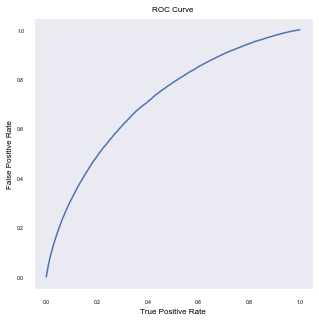

Training set ROC: 0.7131997023596492


In [19]:
#plotting the ROC Curve
trainingSummaryLR = LR_model.summary

roc = trainingSummaryLR.roc.toPandas()
plt.figure(figsize=(5,5))
plt.rc('axes', titlesize=8) 
plt.rc('axes', labelsize=8)
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set ROC: ' + str(trainingSummaryLR.areaUnderROC))

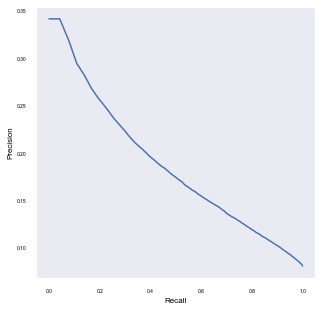

In [20]:
pr = trainingSummaryLR.pr.toPandas()
plt.figure(figsize=(5,5))
plt.rc('axes', titlesize=8) 
plt.rc('axes', labelsize=8)
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

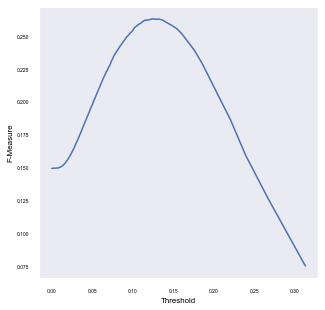

In [21]:
f = trainingSummaryLR.fMeasureByThreshold.toPandas()
plt.figure(figsize=(5,5))
plt.rc('axes', titlesize=8) 
plt.rc('axes', labelsize=8)
plt.plot(f['threshold'],f['F-Measure'])
plt.ylabel('F-Measure')
plt.xlabel('Threshold')
plt.show()

In [22]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

predictions_LR = LR_model.transform(test)
evaluator = BinaryClassificationEvaluator()
print("Test_SET Area Under ROC: " + str(evaluator.evaluate(predictions_LR, {evaluator.metricName: "areaUnderROC"})))

Test_SET Area Under ROC: 0.7029276274697658


In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

evaluator = BinaryClassificationEvaluator()

#create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(LR.regParam, [0.1, 0.3, 0.5]) # regularisation parameter
             .addGrid(LR.elasticNetParam, [0.0, 0.1, 0.2]) # Elastic Net Parameter (Ridge = 0)
             .addGrid(LR.maxIter, [10, 20, 50]) #number of iterations
             .addGrid(LR.numFeatures, [10, 100, 1000]) #number of features
             .build())

#create 5-fold CrossValidator
cvLR = CrossValidator(estimator=LR, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

lrModel = cvLR.fit(train)

#generate predictions with model with best params
predictions = lrModel.transform(test)

#evaluate best model
evaluator.evaluate(predictions)

### Linear Support Vector Machine

In [23]:
from pyspark.ml.classification import LinearSVC

svc = LinearSVC(maxIter=10, regParam=0.1)
SVC_Model = svc.fit(train)

In [24]:
predictions_SVC = SVC_Model.transform(test)
evaluator = BinaryClassificationEvaluator()
print("Test_SET Area Under ROC: " + str(evaluator.evaluate(predictions_SVC, {evaluator.metricName: "areaUnderROC"})))

Test_SET Area Under ROC: 0.5301229453143492


### Decision Tree Classifier

In [25]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
DT_model = dt.fit(train)

In [26]:
predictions_DT = DT_model.transform(test)
evaluator = BinaryClassificationEvaluator()
print("Test_SET Area Under ROC: " + str(evaluator.evaluate(predictions_DT, {evaluator.metricName: "areaUnderROC"})))

Test_SET Area Under ROC: 0.5


In [27]:
print(dt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features, current: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)
labelCol: label column name. (default: label, current: label)
maxBins: Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature. (default: 32)
m

In [ ]:
evaluator = BinaryClassificationEvaluator()

paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)])
             .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)])
             .build())

#create 5-fold CrossValidator
cvDT = CrossValidator(estimator=LR, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

dtModel = cvDT.fit(train)

#generate predictions with model with best params
predictions = dtModel.transform(test)

#evaluate best model
evaluator.evaluate(predictions)

### Gradient Boosted Tree Classifier

In [28]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(maxIter=15)
GBT_model = gbt.fit(train)

In [29]:
predictions = GBT_model.transform(test)
evaluator = BinaryClassificationEvaluator()
print("Test_SET Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test_SET Area Under ROC: 0.7263882908614244


In [30]:
print(gbt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 30])
             .addGrid(gbt.maxIter, [10, 15])
             .build())

cvGBT = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

#run cross validations.
gbtModel = cvGBT.fit(train)

#predictions from model with best params
predictions = gbtModel.transform(test)

#evaluate
evaluator.evaluate(predictions)

### Random Forest Classifier

In [31]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
RF_Model = rf.fit(train)

In [32]:
predictions = RF_Model.transform(test)
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.6554622370506994


In [33]:
print(rf.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, TrainValidationSplit
import numpy as np

paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)])
             .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)])
             .build())

cvRF = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

rfModel = cvRF.fit(train)
predictions = rfModel.transform(test)
evaluator.evaluate(predictions)